In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dual_cell(nx,ny):
    x = np.linspace(-10,10,nx)
    y = np.linspace(-1,1,ny)
    xy = np.zeros((nx*ny,2))
    dx = 20/(nx-1)
    dy = 2/(ny-1)
    A = dx*dy/2
    area = np.zeros(nx*ny)
    edge = np.zeros(((nx-1)*ny+(ny-1)*nx+(nx-1)*(ny-1),2),dtype=int)
    edge_area_normal = np.zeros(((nx-1)*ny+(ny-1)*nx+(nx-1)*(ny-1),2))
    bc_type = np.zeros((2*(nx+ny),2))
    bc_area_normal = np.zeros((2*(nx+ny),2))
    k = 0
    l = 0
    for i in range(len(x)):
        for j in range(len(y)):
            xy[i*ny+j,0] = x[i]
            xy[i*ny+j,1] = y[j]
            if i<nx-1 and j<ny-1:
                edge[l,0] = i*ny+j
                edge[l,1] = (i+1)*ny+j
                edge_area_normal[l,0] = -2*dy/3
                edge_area_normal[l,1] = dx/3
                l += 1
                edge[l,0] = i*ny+j
                edge[l,1] = i*ny+j+1
                edge_area_normal[l,0] = dy/3
                edge_area_normal[l,1] = -2*dx/3
                l += 1
                edge[l,0] = i*ny+j
                edge[l,1] = (i+1)*ny+j+1
                edge_area_normal[l,0] = dy/3
                edge_area_normal[l,1] = dx/3
                l += 1
            elif i==nx-1 and j<ny-1:
                edge[l,0] = i*ny+j
                edge[l,1] = i*ny+j+1
                edge_area_normal[l,0] = dy/3
                edge_area_normal[l,1] = -2*dx/3
                l += 1
            elif i<nx-1 and j==ny-1:
                edge[l,0] = i*ny+j
                edge[l,1] = (i+1)*ny+j
                edge_area_normal[l,0] = -2*dy/3
                edge_area_normal[l,1] = dx/3
                l += 1
            if i==0 or i==nx-1:
                if j==0 or j==ny-1:
                    if (i==0 and j==0) or (i==nx-1 and j==ny-1):
                        area[i*ny+j] = 4*A/6
                    else:
                        area[i*ny+j] = 2*A/6
                    bc_type[k,0] = i*ny+j
                    bc_type[k,1] = 1
                    bc_area_normal[k,0] = 0
                    if j == 0:
                        bc_area_normal[k,1] = -1
                    else:
                        bc_area_normal[k,1] = 1
                    k += 1
                    bc_type[k,0] = i*ny+j
                    bc_type[k,1] = 2
                    bc_area_normal[k,1] = 0
                    if i == 0:
                        bc_area_normal[k,0] = -1
                    else:
                        bc_area_normal[k,0] = 1
                    k += 1
                else:
                    area[i*ny+j] = A
                    bc_type[k,0] = i*ny+j
                    bc_type[k,1] = 2
                    bc_area_normal[k,1] = 0
                    if i == 0:
                        bc_area_normal[k,0] = -1
                    else:
                        bc_area_normal[k,0] = 1
                    k += 1
            else:
                if j==0 or j==ny-1:
                    area[i*ny+j] = A
                    bc_type[k,0] = i*ny+j
                    bc_type[k,1] = 1
                    bc_area_normal[k,0] = 0
                    if j == 0:
                        bc_area_normal[k,1] = -1
                    else:
                        bc_area_normal[k,1] = 1
                    k += 1
                else:
                    area[i*ny+j] = 2*A
            
    return xy,area,edge,edge_area_normal,bc_type,bc_area_normal

In [3]:
# Extraction of physical quantities from W
def Wtovar(W):
    gamma = 1.4
    rho = W[0]
    u = W[1]/W[0]
    v = W[2]/W[0]
    E = W[3]
    P = (E-rho*(v*v+u*u)/2)*(gamma-1)
    h = (E+P)/rho
    return rho,u,v,E,P,h

In [4]:
# ARL matrix
def A_mat(h,u,v,nux,nuy,g):
    a1 = (g-3)*u*u*nux/2+(g-1)*v*v*nux/2-u*v*nuy
    a2 = (g-3)*v*v*nuy/2+(g-1)*u*u*nuy/2-u*v*nux
    a3 = (u*nux+v*nuy)*((g-1)*(u**2+v**2)/2-h)
    return np.array([[0,nux,nuy,0],
            [a1,(3-g)*u*nux+v*nuy,u*nuy-(g-1)*v*nux,(g-1)*nux],
            [a2,v*nux-(g-1)*u*nuy,u*nux+(3-g)*v*nuy,(g-1)*nuy],
    [a3,h*nux-u*(g-1)*(u*nux+v*nuy),h*nuy-v*(g-1)*(u*nux+v*nuy),g*(u*nux+v*nuy)]])

In [5]:
def Roe_flux(Wi,Wj,nij):
    n0ij = nij/np.linalg.norm(nij)
    rhoi,ui,vi,Ei,Pi,hi = Wtovar(Wi)
    rhoj,uj,vj,Ej,Pj,hj = Wtovar(Wj)
    uij = (np.sqrt(rhoi)*ui+np.sqrt(rhoj)*uj)/(np.sqrt(rhoi)+np.sqrt(rhoj))
    vij = (np.sqrt(rhoi)*vi+np.sqrt(rhoj)*vj)/(np.sqrt(rhoi)+np.sqrt(rhoj))
    hij = (np.sqrt(rhoi)*hi+np.sqrt(rhoj)*hj)/(np.sqrt(rhoi)+np.sqrt(rhoj))
    v0i = ui*n0ij[0]+vi*n0ij[1]
    v0j = uj*n0ij[0]+vj*n0ij[1]
    Aij = A_mat(hij,uij,vij,n0ij[0],n0ij[1],1.4)
    a,b = np.linalg.eig(Aij)
    Aij_mod = np.matmul(b,np.matmul(np.diag(np.abs(a)),np.linalg.inv(b)))
    F0i = np.array([rhoi*v0i,rhoi*ui*v0i+Pi*n0ij[0],rhoi*vi*v0i+Pi*n0ij[1],(Ei+Pi)*v0i])
    F0j = np.array([rhoj*v0j,rhoj*uj*v0j+Pj*n0ij[0],rhoj*vj*v0j+Pj*n0ij[1],(Ej+Pj)*v0j])
    F = ((F0i+F0j)-np.matmul(Aij_mod,(Wj-Wi)))*np.linalg.norm(nij)**2/2
    return F

In [6]:
def Wall_flux(Wi,nii):
    rhoi,ui,vi,Ei,Pi,hi = Wtovar(Wi)
    v0i = ui*nii[0]+vi*nii[1]
    return np.array([rhoi*v0i,rhoi*ui*v0i+Pi*nii[0],rhoi*vi*v0i+Pi*nii[1],(Ei+Pi)*v0i])

In [7]:
nx = 100
ny = 20
xy,area,edge,edge_area_normal,bc_type,bc_area_normal = dual_cell(nx,ny)

In [10]:
P = 1e5*np.ones(nx*ny)
rho = np.ones(nx*ny)
u = 100*np.ones(nx*ny)
v = np.zeros(nx*ny)
g = 1.4
P[1000:] = 1e4*np.ones(int(nx*ny/2))
rho[1000:] = 0.125*np.ones(int(nx*ny/2))
u[1000:] = 50*np.ones(int(nx*ny/2))
c = np.sqrt(g*P/rho)
W = np.array([rho,rho*u,rho*v,P/(g-1)+rho*(u**2+v**2)/2]).T
WL = W[0]
WR = W[1000]

In [11]:
T = 0.01
t = 0
dx = 20/(nx-1)
dy = 2/(ny-1)
dt = 1e-4*0.2
WA = []
WB = []
WC = []
WD = []
W2 = W.copy()
W4 = W.copy()
W6 = W.copy()
W8 = W.copy()
W10 = W.copy()
while(t<T):
# for m in range(10):
#     dt = min(dx,dy)/max(np.max(u),np.max(u+c),np.max(u-c))
    W1 = W.copy()
    for i in range(nx):
        for j in range(ny):
            F = 0
            ci = area[i*ny+j]
            if xy[i*ny+j][0] == -10:
                for l in range(len(bc_type)):
                    if i*ny+j == bc_type[l][0]:
                        if type(Roe_flux(W[i*ny+j],WL,bc_area_normal[l])[0])!=np.complex128:
                            F += Roe_flux(W[i*ny+j],WL,bc_area_normal[l])
            elif xy[i*ny+j][0] == 10:
                for l in range(len(bc_type)):
                    if i*ny+j == bc_type[l][0]:
                        if type(Roe_flux(W[i*ny+j],WR,bc_area_normal[l])[0])!=np.complex128:
                            F += Roe_flux(W[i*ny+j],WR,bc_area_normal[l])
            elif xy[i*ny+j][1] == -1:
                for l in range(len(bc_type)):
                    if i*ny+j == bc_type[l][0]:
                        F += Wall_flux(W[i*ny+j],bc_area_normal[l])
            elif xy[i*ny+j][1] == 1:
                for l in range(len(bc_type)):
                    if i*ny+j == bc_type[l][0]:
                        F += Wall_flux(W[i*ny+j],bc_area_normal[l])
            else:
                for k in range(len(edge)):
                    if i*ny+j == edge[k][0]:
                        if (type(Roe_flux(W[edge[k][0]],W[edge[k][1]],edge_area_normal[k])[0])!=np.complex128):
                            F += Roe_flux(W[edge[k][0]],W[edge[k][1]],edge_area_normal[k])
                    elif i*ny+j == edge[k][1]:
                        if (type(Roe_flux(W[edge[k][1]],W[edge[k][0]],-edge_area_normal[k])[0])!=np.complex128):
                            F += Roe_flux(W[edge[k][1]],W[edge[k][0]],-edge_area_normal[k])
            W1[i*ny+j] = W[i*ny+j]-dt*F/ci
    W = W1.copy()
    WA.append(W[989])
    WB.append(W[1009])
    WC.append(W[1010])
    WD.append(W[1019])
    if np.round(t,5) == 0.002:
        W2 = W.copy()
    if np.round(t,5) == 0.004:
        W4 = W.copy()
    if np.round(t,5) == 0.006:
        W6 = W.copy()
    if np.round(t,5) == 0.008:
        W8 = W.copy()
    if np.round(t,5) == 0.01:
        W10 = W.copy()
    print(t)
    t += dt

0


KeyboardInterrupt: 

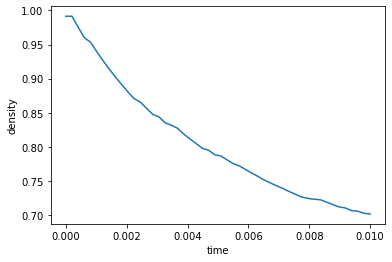

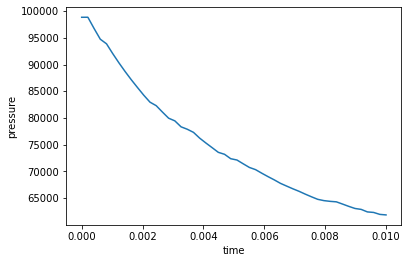

In [305]:
WA = np.array(WA).T
rhoA,_,_,_,PA,_ = Wtovar(WA)
xaxis = np.linspace(0,0.01,len(WA.T))
plt.plot(xaxis,rhoA)
plt.xlabel('time')
plt.ylabel('density')
plt.show()
plt.plot(xaxis,PA)
plt.xlabel('time')
plt.ylabel('pressure')
plt.show()

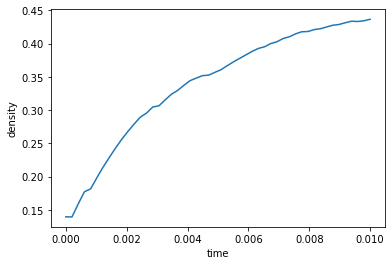

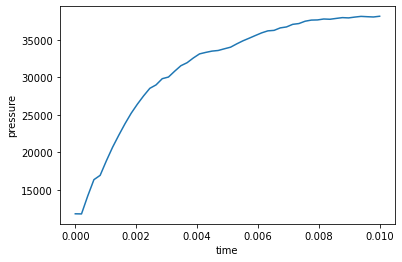

In [307]:
WB = np.array(WB).T
rhoB,_,_,_,PB,_ = Wtovar(WB)
xaxis = np.linspace(0,0.01,len(WB.T))
plt.plot(xaxis,rhoB)
plt.xlabel('time')
plt.ylabel('density')
plt.show()
plt.plot(xaxis,PB)
plt.xlabel('time')
plt.ylabel('pressure')
plt.show()

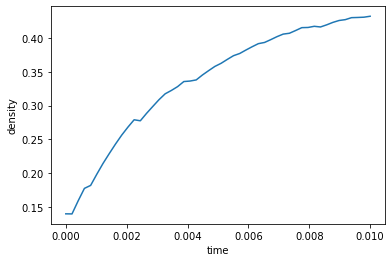

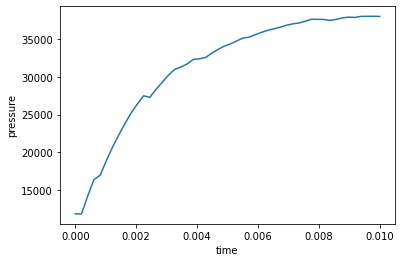

In [309]:
WC = np.array(WC).T
rhoC,_,_,_,PC,_ = Wtovar(WC)
xaxis = np.linspace(0,0.01,len(WC.T))
plt.plot(xaxis,rhoC)
plt.xlabel('time')
plt.ylabel('density')
plt.show()
plt.plot(xaxis,PC)
plt.xlabel('time')
plt.ylabel('pressure')
plt.show()

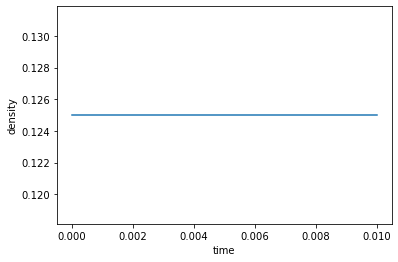

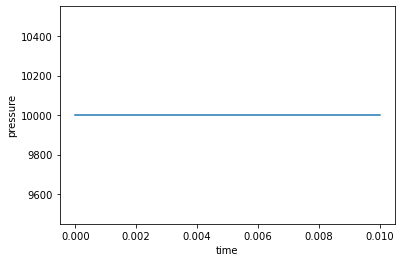

In [311]:
WD = np.array(WD).T
rhoD,_,_,_,PD,_ = Wtovar(WD)
xaxis = np.linspace(0,0.01,len(WD.T))
plt.plot(xaxis,rhoD)
plt.xlabel('time')
plt.ylabel('density')
plt.show()
plt.plot(xaxis,PD)
plt.xlabel('time')
plt.ylabel('pressure')
plt.show()

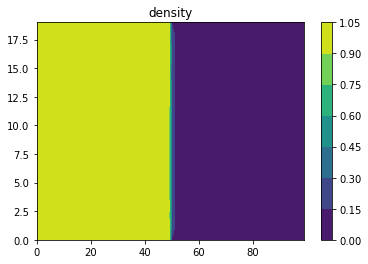

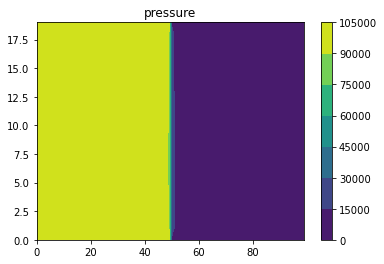

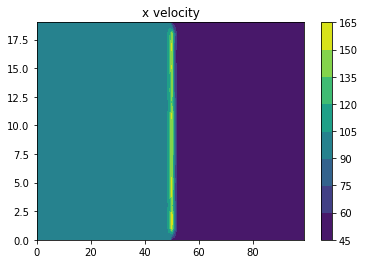

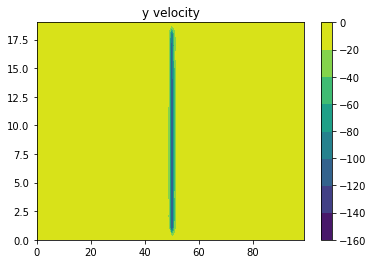

In [313]:
W2 = np.array(W2).T
rho2,u2,v2,_,P2,_ = Wtovar(W2)
rho21 = np.reshape(rho2,(100,20))
plt.contourf(rho21.T)
plt.title('density')
plt.colorbar()
plt.show()
p21 = np.reshape(P2,(100,20))
plt.contourf(p21.T)
plt.title('pressure')
plt.colorbar()
plt.show()
u21 = np.reshape(u2,(100,20))
plt.contourf(u21.T)
plt.title('x velocity')
plt.colorbar()
plt.show()
v21 = np.reshape(v2,(100,20))
plt.contourf(v21.T)
plt.title('y velocity')
plt.colorbar()
plt.show()

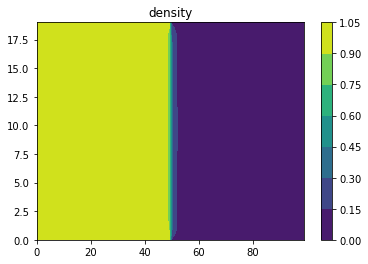

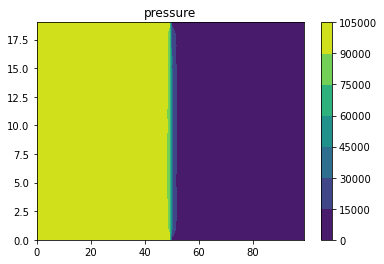

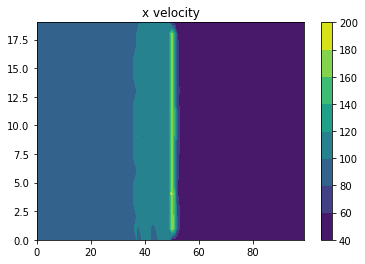

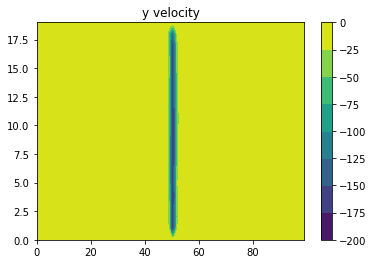

In [315]:
W4 = np.array(W4).T
rho2,u2,v2,_,P2,_ = Wtovar(W4)
rho21 = np.reshape(rho2,(100,20))
plt.contourf(rho21.T)
plt.title('density')
plt.colorbar()
plt.show()
p21 = np.reshape(P2,(100,20))
plt.contourf(p21.T)
plt.title('pressure')
plt.colorbar()
plt.show()
u21 = np.reshape(u2,(100,20))
plt.contourf(u21.T)
plt.title('x velocity')
plt.colorbar()
plt.show()
v21 = np.reshape(v2,(100,20))
plt.contourf(v21.T)
plt.title('y velocity')
plt.colorbar()
plt.show()

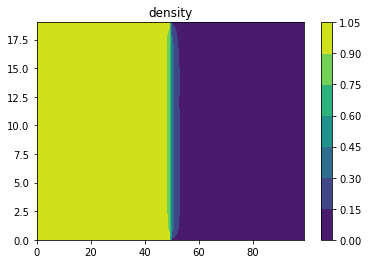

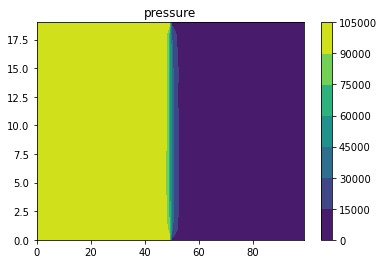

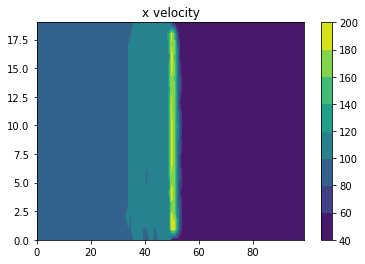

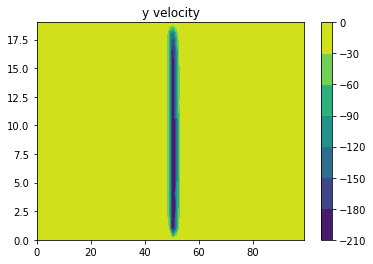

In [317]:
W6 = np.array(W6).T
rho2,u2,v2,_,P2,_ = Wtovar(W6)
rho21 = np.reshape(rho2,(100,20))
plt.contourf(rho21.T)
plt.title('density')
plt.colorbar()
plt.show()
p21 = np.reshape(P2,(100,20))
plt.contourf(p21.T)
plt.title('pressure')
plt.colorbar()
plt.show()
u21 = np.reshape(u2,(100,20))
plt.contourf(u21.T)
plt.title('x velocity')
plt.colorbar()
plt.show()
v21 = np.reshape(v2,(100,20))
plt.contourf(v21.T)
plt.title('y velocity')
plt.colorbar()
plt.show()

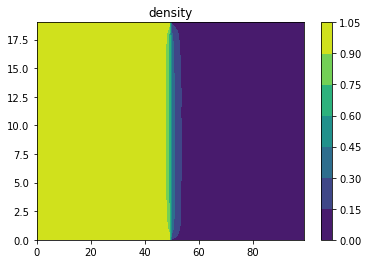

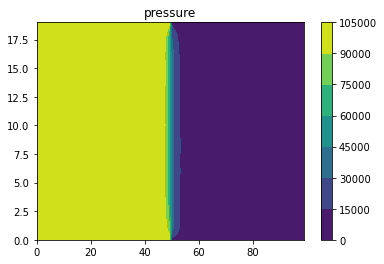

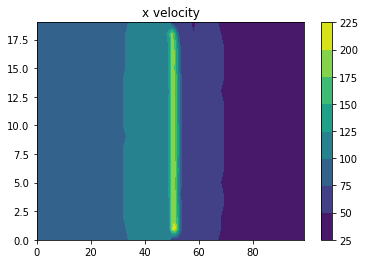

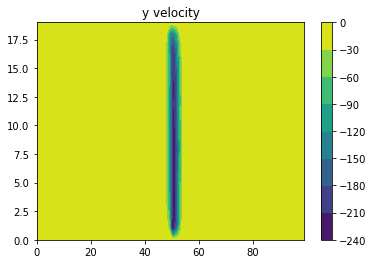

In [319]:
W8 = np.array(W8).T
rho2,u2,v2,_,P2,_ = Wtovar(W8)
rho21 = np.reshape(rho2,(100,20))
plt.contourf(rho21.T)
plt.title('density')
plt.colorbar()
plt.show()
p21 = np.reshape(P2,(100,20))
plt.contourf(p21.T)
plt.title('pressure')
plt.colorbar()
plt.show()
u21 = np.reshape(u2,(100,20))
plt.contourf(u21.T)
plt.title('x velocity')
plt.colorbar()
plt.show()
v21 = np.reshape(v2,(100,20))
plt.contourf(v21.T)
plt.title('y velocity')
plt.colorbar()
plt.show()

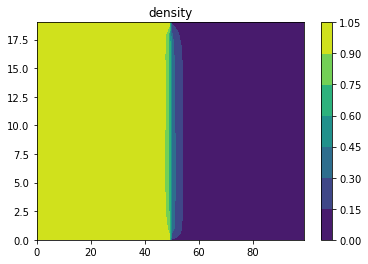

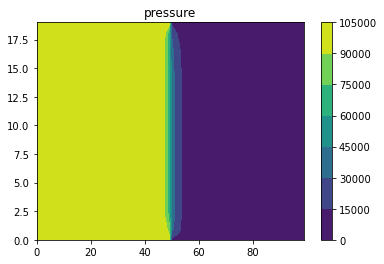

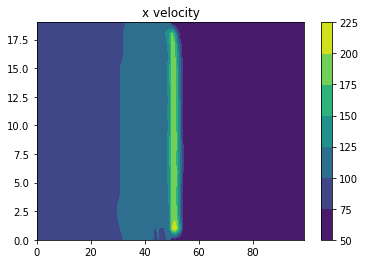

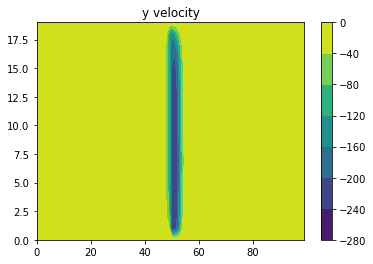

In [321]:
W10 = np.array(W).T
rho2,u2,v2,_,P2,_ = Wtovar(W10)
rho21 = np.reshape(rho2,(100,20))
plt.contourf(rho21.T)
plt.title('density')
plt.colorbar()
plt.show()
p21 = np.reshape(P2,(100,20))
plt.contourf(p21.T)
plt.title('pressure')
plt.colorbar()
plt.show()
u21 = np.reshape(u2,(100,20))
plt.contourf(u21.T)
plt.title('x velocity')
plt.colorbar()
plt.show()
v21 = np.reshape(v2,(100,20))
plt.contourf(v21.T)
plt.title('y velocity')
plt.colorbar()
plt.show()